### Figure 3 | Transcriptome-based models discriminate sarcoidosis more accurately than demographic features
Comparison of cross-validated classification performance using transcriptomic features, principal components, and demographic variables.

NULL


  HC SARC 
  76   31 

Demographics-only: using 107 samples from 29 subjects


Model,AUC
<chr>,<dbl>
Gene elastic net,0.9762309
PC ridge (20 PCs),0.9049236
Clinical ridge (age+bmi+sex+race+tx),0.9219015
Demographics ridge (age+bmi+sex+race),0.8421053


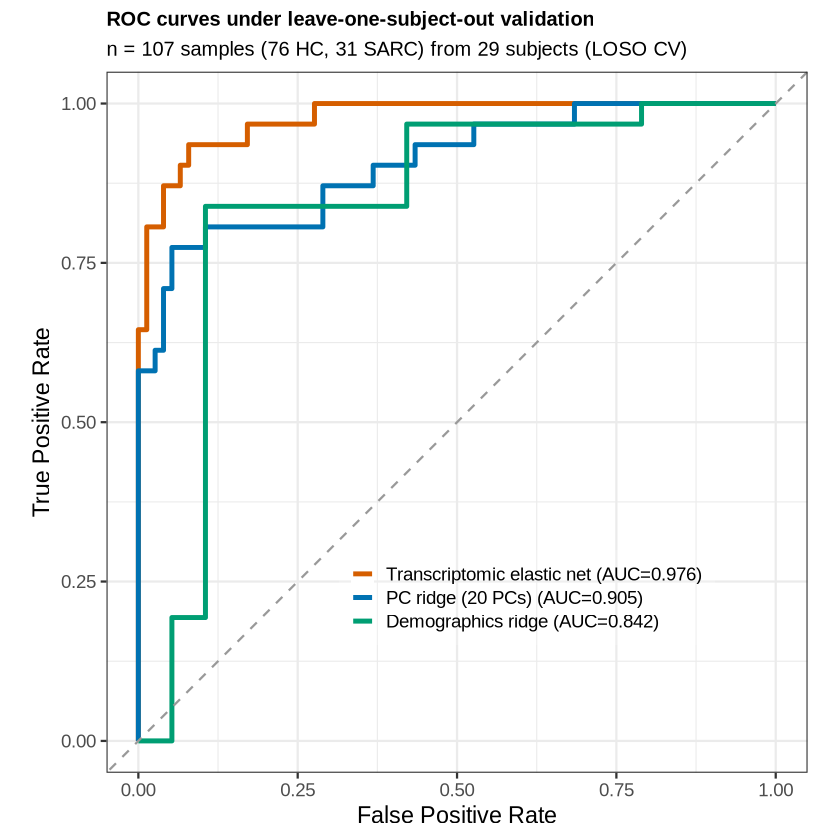

In [6]:
suppressPackageStartupMessages({
  library(DESeq2)
  library(SummarizedExperiment)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(readr)
  library(stringr)
  library(S4Vectors)
  library(vegan)        # PERMANOVA (adonis2)
  library(matrixStats)  # rowVars
  library(tibble)
  library(uwot)         # UMAP
  library(dplyr)
  library(glmnet)
  library(pROC)
})


set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_all_final.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se <- readRDS(SE_RDS)

bundle <- readRDS(here::here("data", "derived", "fig_inputs_umap_vst_top1000_hc_sarc.rds"))
mat_top <- bundle$mat_top
df_hc   <- bundle$df_hc
cd      <- bundle$cd


suppressPackageStartupMessages({

})

## Sanity check on mat_top / df_hc alignment
samples_use <- df_hc$sample_id
mat_use <- mat_top[, samples_use, drop = FALSE]
stopifnot(identical(colnames(mat_use), df_hc$sample_id))

## Convenient vectors
y_fac   <- droplevels(df_hc$Group2)            # factor: HC / SARC
y_bin   <- ifelse(y_fac == "SARC", 1, 0)
subj_id <- df_hc$m_subj2                       # subject ID for LOSO
subjects <- unique(subj_id)

## Storage for predictions
pred_gene        <- rep(NA_real_, length(y_bin))
pred_pc          <- rep(NA_real_, length(y_bin))
pred_clin_glmnet <- rep(NA_real_, length(y_bin))
pred_dem         <- rep(NA_real_, length(y_bin))  # demographics-only; subset will be filled

## ============================================================
## 1) Gene-level elastic net (primary transcriptomic model)
## ============================================================

X_gene <- t(mat_use)   # samples x genes

set.seed(42)
for (s in subjects) {
  test_idx  <- which(subj_id == s)
  train_idx <- setdiff(seq_len(nrow(X_gene)), test_idx)

  x_train <- X_gene[train_idx, , drop = FALSE]
  x_test  <- X_gene[test_idx, , drop = FALSE]
  y_train <- y_bin[train_idx]

  fit_en <- cv.glmnet(
    x_train, y_train,
    family = "binomial",
    alpha  = 0.5,       # elastic net
    nfolds = 5
  )

  pred_gene[test_idx] <- as.numeric(
    predict(fit_en, x_test, s = "lambda.min", type = "response")
  )
}

roc_gene <- roc(y_fac, pred_gene, levels = c("HC", "SARC"), quiet = TRUE)
auc_gene <- as.numeric(roc_gene$auc)
# auc_gene

## ============================================================
## 2) PC-based ridge logistic (20 PCs)
## ============================================================

pc <- prcomp(t(mat_use), center = TRUE, scale. = TRUE)
n_pc <- 20
pc_scores <- pc$x[, 1:n_pc]  # samples x PCs

dat_pc <- as.data.frame(pc_scores) %>%
  mutate(
    Group2 = y_fac,
    subj2  = subj_id
  )

X_pc   <- as.matrix(dat_pc[, 1:n_pc])
y_pc   <- ifelse(dat_pc$Group2 == "SARC", 1, 0)
subj_pc <- dat_pc$subj2

set.seed(42)
for (s in subjects) {
  test_idx  <- which(subj_pc == s)
  train_idx <- setdiff(seq_len(nrow(dat_pc)), test_idx)

  x_train <- X_pc[train_idx, , drop = FALSE]
  x_test  <- X_pc[test_idx, , drop = FALSE]
  y_train <- y_pc[train_idx]

  fit_ridge <- cv.glmnet(
    x_train, y_train,
    family = "binomial",
    alpha  = 0,         # ridge
    nfolds = 5
  )

  pred_pc[test_idx] <- as.numeric(
    predict(fit_ridge, x_test, s = "lambda.min", type = "response")
  )
}

roc_pc <- roc(y_fac, pred_pc, levels = c("HC", "SARC"), quiet = TRUE)
auc_pc <- as.numeric(roc_pc$auc)
# auc_pc

## ============================================================
## 3) Clinical glmnet (age, BMI, sex, race, steroid, antimetab) Sanitiy check
## ============================================================

cd_hc <- cd %>%
  as.data.frame() %>%
  filter(sample_id %in% df_hc$sample_id) %>%
  arrange(match(sample_id, df_hc$sample_id))

stopifnot(identical(cd_hc$sample_id, df_hc$sample_id))

clin_dat <- cd_hc %>%
  mutate(
    Group2 = factor(
      ifelse(TxGroup == "HC", "HC", "SARC"),
      levels = c("HC", "SARC")
    ),
    subj2  = m_subj2,

    sex_F   = ifelse(m_sex  == "W", 1, 0),
    race_AA = ifelse(m_race == "AA", 1, 0),

    steroid_bin   = ifelse(is.na(m_steroid)   | m_steroid   == 0, 0, 1),
    antimetab_bin = ifelse(is.na(m_antimetab) | m_antimetab == 0, 0, 1),

    age = as.numeric(m_age),
    bmi = as.numeric(m_bmi)
  ) %>%
  dplyr::select(
    Group2, subj2,
    age, bmi,
    sex_F, race_AA,
    steroid_bin, antimetab_bin
  )

X_clin        <- as.matrix(clin_dat %>% dplyr::select(-Group2, -subj2))
y_fac_clin    <- clin_dat$Group2
y_bin_clin    <- ifelse(y_fac_clin == "SARC", 1, 0)
subj_clin     <- clin_dat$subj2
subjects_clin <- unique(subj_clin)

set.seed(42)
for (s in subjects_clin) {
  test_idx  <- which(subj_clin == s)
  train_idx <- setdiff(seq_len(nrow(clin_dat)), test_idx)

  x_train <- X_clin[train_idx, , drop = FALSE]
  x_test  <- X_clin[test_idx, , drop = FALSE]
  y_train <- y_bin_clin[train_idx]

  fit_ridge_clin <- cv.glmnet(
    x_train, y_train,
    family = "binomial",
    alpha  = 0,         # ridge
    nfolds = 5
  )

  pred_clin_glmnet[test_idx] <- as.numeric(
    predict(fit_ridge_clin, x_test, s = "lambda.min", type = "response")
  )
}

keep_clin <- !is.na(pred_clin_glmnet)
table(y_fac_clin[keep_clin])

roc_clin_glmnet <- roc(
  y_fac_clin[keep_clin],
  pred_clin_glmnet[keep_clin],
  levels = c("HC", "SARC"),
  quiet = TRUE
)
auc_clin_glmnet <- as.numeric(roc_clin_glmnet$auc)
# auc_clin_glmnet

## ============================================================
## 4) Demographics-only glmnet (age, BMI, sex, race_AA)
##     (no treatment variables; complete-case only)
## ============================================================

dem_dat <- cd_hc %>%
  mutate(
    Group2 = factor(ifelse(TxGroup == "HC", "HC", "SARC"), levels = c("HC", "SARC")),
    subj2  = m_subj2,
    sample_id = sample_id,

    sex_F   = ifelse(m_sex  == "W", 1, 0),
    race_AA = ifelse(m_race == "AA", 1, 0),

    age = as.numeric(m_age),
    bmi = as.numeric(m_bmi)
  ) %>%
  dplyr::select(sample_id, Group2, subj2, age, bmi, sex_F, race_AA)

pred_cols <- c("age", "bmi", "sex_F", "race_AA")
keep_rows <- complete.cases(dem_dat[, pred_cols])

dem_dat_cc <- dem_dat[keep_rows, ]
X_dem      <- as.matrix(dem_dat_cc %>% dplyr::select(all_of(pred_cols)))
y_fac_dem  <- dem_dat_cc$Group2
y_bin_dem  <- ifelse(y_fac_dem == "SARC", 1, 0)
subj_dem   <- dem_dat_cc$subj2
subjects_dem <- unique(subj_dem)

cat("Demographics-only: using", nrow(dem_dat_cc), "samples from",
    length(subjects_dem), "subjects\n")

pred_dem_cc <- rep(NA_real_, nrow(dem_dat_cc))

set.seed(42)
for (s in subjects_dem) {
  test_idx  <- which(subj_dem == s)
  train_idx <- setdiff(seq_len(nrow(dem_dat_cc)), test_idx)

  x_train <- X_dem[train_idx, , drop = FALSE]
  x_test  <- X_dem[test_idx, , drop = FALSE]
  y_train <- y_bin_dem[train_idx]

  fit_ridge_dem <- cv.glmnet(
    x_train, y_train,
    family = "binomial",
    alpha  = 0,
    nfolds = 5
  )

  pred_dem_cc[test_idx] <- as.numeric(
    predict(fit_ridge_dem, x_test, s = "lambda.min", type = "response")
  )
}

roc_dem <- roc(y_fac_dem, pred_dem_cc, levels = c("HC", "SARC"), quiet = TRUE)
auc_dem <- as.numeric(roc_dem$auc)
# auc_dem

## ============================================================
## 5) Bind predictions and summarize AUCs
## ============================================================

df_preds <- df_hc %>%
  dplyr::select(sample_id, Group2, m_subj2) %>%
  mutate(
    p_gene = pred_gene,
    p_pc   = pred_pc
  )

# attach treatment-inclusive clinical predictions if you still want it (optional)
df_preds$p_clin_tx <- pred_clin_glmnet  # from your section 3

# attach demographics-only predictions only for complete-cases
df_preds$p_dem <- NA_real_
idx_dem <- match(dem_dat_cc$sample_id, df_preds$sample_id)
df_preds$p_dem[idx_dem] <- pred_dem_cc


results_summary <- tibble::tibble(
  Model    = c("Gene elastic net", "PC ridge (20 PCs)",
               "Clinical ridge (age+bmi+sex+race+tx)",
               "Demographics ridge (age+bmi+sex+race)"),
  AUC      = c(auc_gene, auc_pc, auc_clin_glmnet, auc_dem)
)

results_summary

library(ggplot2)
library(pROC)
library(dplyr)

# keep only rows where all 3 models have predictions
keep_plot <- complete.cases(df_preds[, c("p_gene","p_pc","p_dem")])
dfp <- df_preds[keep_plot, ]

n_total <- nrow(dfp)
n_hc    <- sum(dfp$Group2 == "HC")
n_sarc  <- sum(dfp$Group2 == "SARC")
n_subj  <- length(unique(dfp$m_subj2))

subtitle_txt <- paste0(
  "n = ", n_total, " samples (", n_hc, " HC, ", n_sarc,
  " SARC) from ", n_subj, " subjects (LOSO CV)"
)

roc_gene_obj <- roc(dfp$Group2, dfp$p_gene, levels = c("HC","SARC"), quiet = TRUE)
roc_pc_obj   <- roc(dfp$Group2, dfp$p_pc,   levels = c("HC","SARC"), quiet = TRUE)
roc_dem_obj  <- roc(dfp$Group2, dfp$p_dem,  levels = c("HC","SARC"), quiet = TRUE)

auc_gene <- sprintf("%.3f", as.numeric(roc_gene_obj$auc))
auc_pc   <- sprintf("%.3f", as.numeric(roc_pc_obj$auc))
auc_dem  <- sprintf("%.3f", as.numeric(roc_dem_obj$auc))

lab_gene <- paste0("Transcriptomic elastic net (AUC=", auc_gene, ")")
lab_pc   <- paste0("PC ridge (20 PCs) (AUC=", auc_pc, ")")
lab_dem  <- paste0("Demographics ridge (AUC=", auc_dem, ")")

roc_df <- bind_rows(
  data.frame(model = lab_gene,
             tpr = rev(roc_gene_obj$sensitivities),
             fpr = rev(1 - roc_gene_obj$specificities)),
  data.frame(model = lab_pc,
             tpr = rev(roc_pc_obj$sensitivities),
             fpr = rev(1 - roc_pc_obj$specificities)),
  data.frame(model = lab_dem,
             tpr = rev(roc_dem_obj$sensitivities),
             fpr = rev(1 - roc_dem_obj$specificities))
)

roc_df$model <- factor(roc_df$model, levels = c(lab_gene, lab_pc, lab_dem))

curve_cols <- c("#D55E00", "#0072B2", "#009E73")
names(curve_cols) <- levels(roc_df$model)

p_roc <- ggplot(roc_df, aes(x = fpr, y = tpr, color = model)) +
  geom_line(linewidth = 1.4) +
  geom_abline(linetype = "dashed", color = "grey60") +
  scale_color_manual(values = curve_cols) +
  coord_equal() +
  theme_bw(base_size = 14) +
  labs(
    title    = "ROC curves under leave-one-subject-out validation",
    subtitle = subtitle_txt,
    x = "False Positive Rate",
    y = "True Positive Rate",
    color = NULL
  ) +
  theme(
    legend.position = c(0.6, 0.25),
    legend.background = element_rect(fill = scales::alpha("white", 0.2), color = NA),
    legend.key.size = grid::unit(0.5, "cm"),
    plot.title = element_text(size = 12, face = "bold"),
    plot.subtitle = element_text(size = 12)
  )

p_roc

# Save figure
FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

ggsave(file.path(FIG_DIR, "Fig3_roc_curves_loso_cv.png"), p_roc, width = 7, height = 6, dpi = 600)
ggsave(file.path(FIG_DIR, "Fig3_roc_curves_loso_cv.pdf"), p_roc, width = 7, height = 6, dpi = 600)